In [1]:
import librosa
from pysndfx import AudioEffectsChain
import numpy as np
import python_speech_features
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

import IPython
import os

# 1. Functions

### Load the file, Return audio time series (y) and sampling rate (sr)

In [2]:
def read_file(file_name):
    sample_file = file_name
    sample_path = 'Samples/'+ sample_file

    # generating audio time series and a sampling rate (int)
    y, sr = librosa.load(sample_path)

    return y, sr

### Noise Reduction using four different methods

In [3]:
def reduce_noise_power(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = round(np.median(cent))*1.5
    threshold_l = round(np.median(cent))*0.1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.8).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5)#.limiter(gain=6.0)
    y_clean = less_noise(y)

    return y_clean

In [4]:
def reduce_noise_median(y, sr):
    y = sp.signal.medfilt(y,3)
    return (y)

In [5]:
def reduce_noise_mfcc_down(y, sr):

    hop_length = 512

    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.6).limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

In [6]:
def reduce_noise_mfcc_up(y, sr):

    hop_length = 512

    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().lowshelf(frequency=min_hz*(-1), gain=12.0, slope=0.5)#.highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.5)#.limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

### Trim Silence and Enhance the Audio

In [7]:
def trim_silence(y):
    y_trimmed, index = librosa.effects.trim(y, top_db=20, frame_length=2, hop_length=500)
    trimmed_length = librosa.get_duration(y) - librosa.get_duration(y_trimmed)

    return y_trimmed, trimmed_length

def enhance(y):
    apply_audio_effects = AudioEffectsChain().lowshelf(gain=10.0, frequency=260, slope=0.1).reverb(reverberance=25, hf_damping=5, room_scale=5, stereo_depth=50, pre_delay=20, wet_gain=0, wet_only=False)#.normalize()
    y_enhanced = apply_audio_effects(y)

    return y_enhanced

### Output in .wav format (TBC)

In [8]:
import soundfile as sf
def output_file(destination ,filename, y, sr, ext=""):
    destination = destination + filename[:-4] + ext + '.wav'
    sf.write(destination, y, sr, 'PCM_16') # recommended to save audio in subtype 16 bits - for google cloud stt API

# 2. Run the sample files and Get the Results
Process:
1. Load the sample files
    
2. Reduce Noise
    
3. Trim Silence
    
4. Save the output

In [9]:
if not os.path.exists('Samples/Sample_Results'):
    os.makedirs('Samples/Sample_Results')

In [10]:
samples = ['A1_with_noise.wav','A2_with_noise.wav','MPF check restaurant surroundings.m4a']

In [11]:
for s in samples:
    # reading a file
    filename = s
    y, sr = read_file(filename)

    # reducing noise using db power
    y_reduced_power = reduce_noise_power(y, sr)
    y_reduced_mfcc_up = reduce_noise_mfcc_up(y, sr)
    y_reduced_mfcc_down = reduce_noise_mfcc_down(y, sr)
    y_reduced_median = reduce_noise_median(y, sr)

    # trimming silences
    y_reduced_power, time_trimmed = trim_silence(y_reduced_power)
    print ("Trimmed time of Sample {} under pwr method: {}".format(s,time_trimmed))
    
    y_reduced_mfcc_up, time_trimmed = trim_silence(y_reduced_mfcc_up)

    y_reduced_mfcc_down, time_trimmed = trim_silence(y_reduced_mfcc_down)

    y_reduced_median, time_trimmed = trim_silence(y_reduced_median)
    

    # generating output file    
    output_file('Samples/Sample_Results/' ,filename, y_reduced_power, sr, '_pwr')
    output_file('Samples/Sample_Results/' ,filename, y_reduced_mfcc_up, sr, '_mfcc_up')
    output_file('Samples/Sample_Results/' ,filename, y_reduced_mfcc_down, sr, '_mfcc_down')
    output_file('Samples/Sample_Results/' ,filename, y_reduced_median, sr, '_median')

Trimmed time of Sample A1_with_noise.wav under pwr method: 0.6925623582766436
Trimmed time of Sample A2_with_noise.wav under pwr method: 0.23904761904761873


/Users/chuanyu/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Trimmed time of Sample MPF check restaurant surroundings.m4a under pwr method: 0.3590022675736959


# 3. Noise Reduction Performance Review

### 3.1. English Sample with single-sourced noise

In [12]:
print("Display the original audio file: ")
original_data, sample_rate = read_file('A1_with_noise.wav')
IPython.display.Audio(data=original_data, rate=sample_rate)

Display the original audio file: 


In [13]:
print("Display the audio after noise reduction: ")
nr_data, sample_rate = read_file('Sample_Results/A1_with_noise_pwr.wav')
IPython.display.Audio(data=nr_data, rate=sample_rate)

Display the audio after noise reduction: 


Plot Before Noise Reduction: 


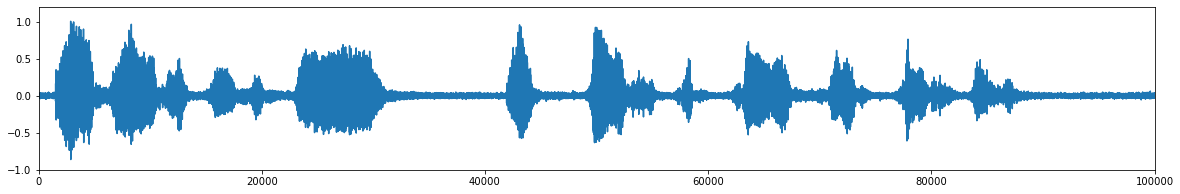

In [14]:
print ("Plot Before Noise Reduction: ")
fig, ax = plt.subplots(figsize=(20,3))
plt.xlim(0, 100000)
plt.ylim(-1,1.2)
ax.plot(original_data)

Plot After Noise Reduction: 


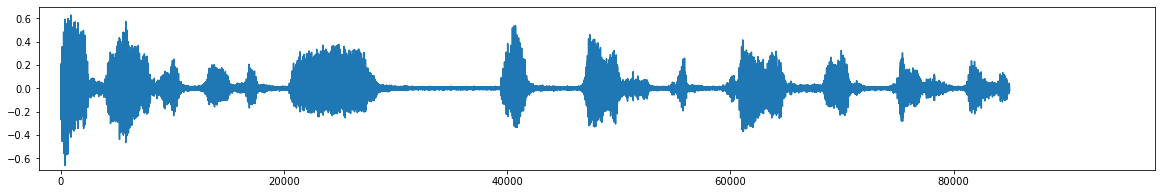

In [15]:
print ("Plot After Noise Reduction: ")
fig, ax = plt.subplots(figsize=(20,3))
plt.xlim(-2000, 98000)
plt.ylim(-0.7,0.7)
ax.plot(nr_data)

### 3.2. Cantonese Sample with noise in restaurant surroundings

In [16]:
print("Display the original audio file: ")
original_data, sample_rate = read_file('MPF check restaurant surroundings.m4a')
IPython.display.Audio(data=original_data, rate=sample_rate)

Display the original audio file: 


/Users/chuanyu/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [17]:
print("Display the audio after noise reduction: ")
nr_data, sample_rate = read_file('Sample_Results/MPF check restaurant surroundings_pwr.wav')
IPython.display.Audio(data=nr_data, rate=sample_rate)

Display the audio after noise reduction: 


Plot Before Noise Reduction: 


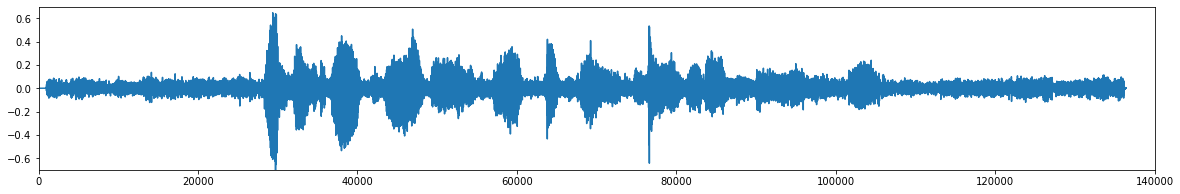

In [18]:
print ("Plot Before Noise Reduction: ")
fig, ax = plt.subplots(figsize=(20,3))
plt.xlim(0, 140000)
plt.ylim(-0.7,0.7)
ax.plot(original_data)

Plot After Noise Reduction: 


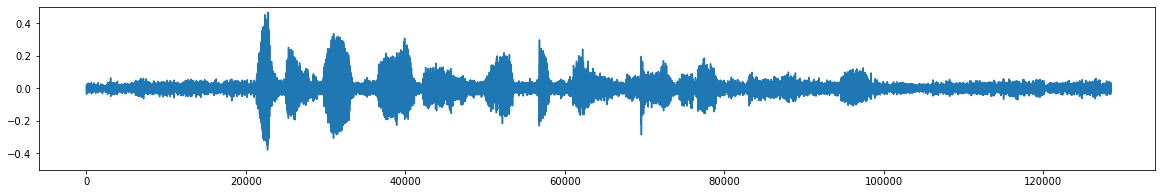

In [19]:
print ("Plot After Noise Reduction: ")
fig, ax = plt.subplots(figsize=(20,3))
plt.xlim(-6000, 134000)
plt.ylim(-0.5,0.5)
ax.plot(nr_data)

# 4. Summary & Improvement Areas:

1. This noise reduction MVP is a non-ML/DL approach, it can identify simple-pattern noise and reduce the noise in speech. 

2. When there is real-life background noise without a simple pattern, we may consider DNN approach to distinguish the speech from noise by learning the patterns of various kinds of noise from a large training set.

3. Next Step: research for a pre-trained DNN model which can be applied to split our speech and noise 